# Epic Poetry using Recurrent Neural Networks (LSTM)

Being a huge fan of J.R. Tolkien's work of fiction, Lord of The Rings, I decided to create an LSTM-based RNN to build poetry using Tolkien's own text as a corpus. Specifically, I used the poems in the books to try and leverage the LSTM's attention to sequences to pick up on some of his writing style.

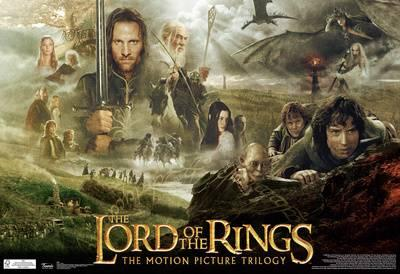

In [1]:
from IPython.display import Image
Image(filename='lotr-movie.jpg') 

## Sequence-2-Sequence Architecture

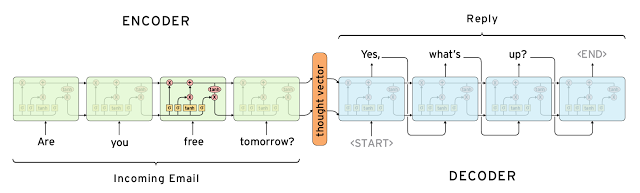

In [2]:
Image(filename='seq2seq.png')

The general sequence-to-sequence architecture looks like a standard encoder/decoder setup. The inputs are of the same size as the outputs and are transformed into an intermediate vector notation called a __thought vector__.

### Attention

Attention tries to establish direct short-cut connections between the target and the source by paying "attention" to relevant source content as it is translated. This augments the training and testing accuracies, adding a significant improvement over non-attentive models (see citations below). The attention vector and __context vector__ (another way of calling the thought vector) can be derived mathematically as shown below:

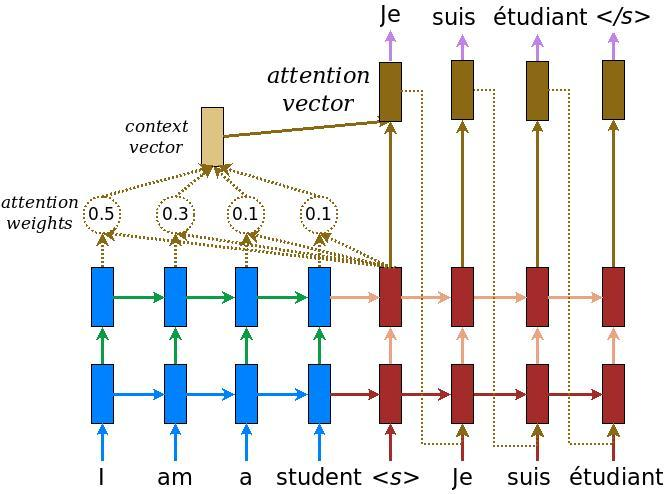

In [3]:
Image(filename='attention_mechanism.jpg')

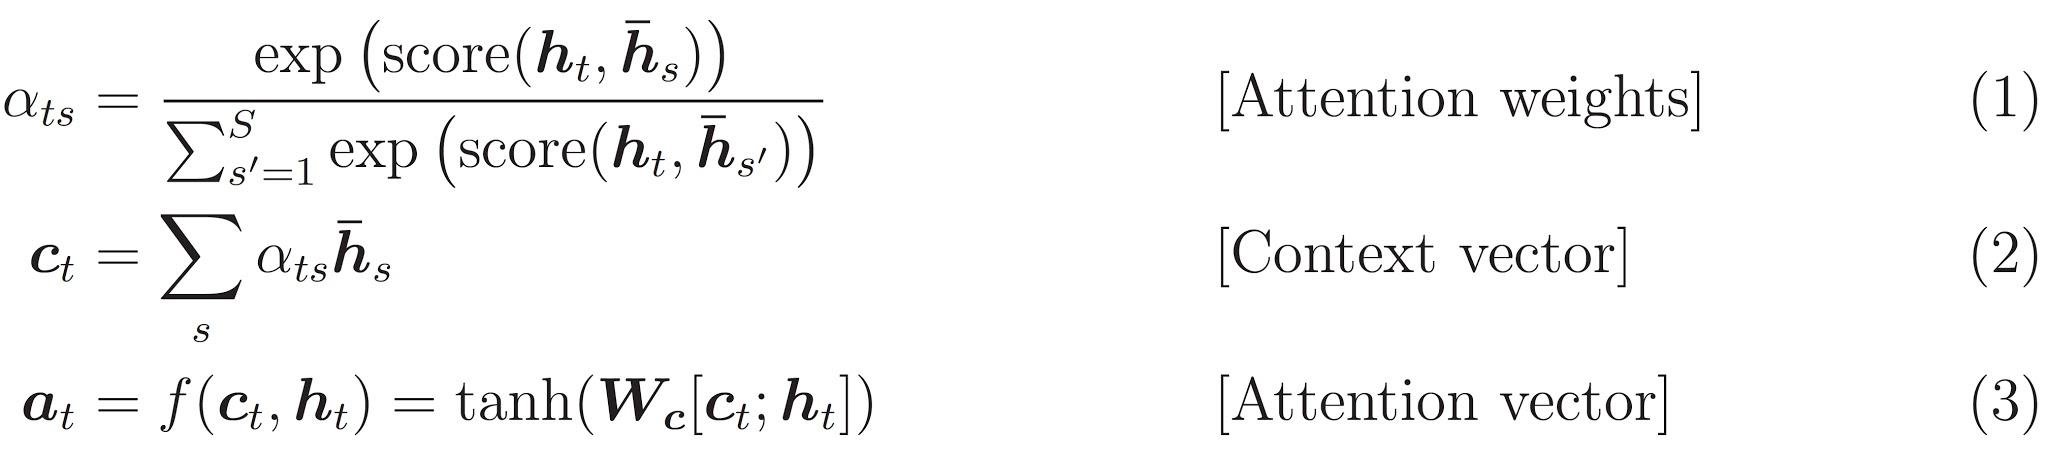

In [4]:
Image(filename='attention_equation.jpg')

## Handling Imports

C:\Users\Avinash Venugopal\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


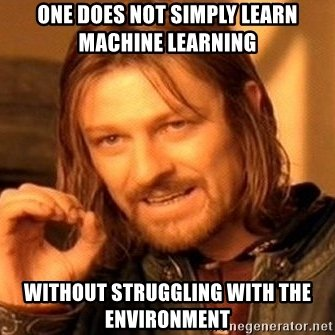

In [5]:
import re
import numpy as np
import tensorflow as tf
import helpers
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

tf.reset_default_graph()
sess=tf.InteractiveSession()
Image(filename='truth.jpg')

## Preprocessing

In [6]:
word_reverse_dict = {} # Each word will have unique number corresponding to it
dict_value = 1 # Starting value for word reverse mapping

In [7]:
with open('sauron.txt') as handle:
    poem_data = list(handle)

poem_data = poem_data[:-1] 

for poem in poem_data:
    words = re.sub(':,.!?',' ',poem)
    wordList = set(words.split())
    for word in wordList:
        if word not in word_reverse_dict:
            word_reverse_dict[word] = dict_value
            dict_value+=1

ivd = {v:k for k,v in word_reverse_dict.items()} # Inverted-lookup dictionary; for output decoding
print("")
print("Three Rings for the Elven-kings under the sky,\nSeven for the Dwarf-lords in their halls of stone,\nNine for Mortal Men doomed to die,\nOne for the Dark Lord on his dark throne,\nIn the Land of Mordor where the Shadows lie,\nOne Ring to rule them all,\nOne Ring to find them,\nOne Ring to bring them all,\nand in the darkness bind them,\nIn the Land of Mordor where the Shadows lie")
print("---")
print("Found %d distinct words."%(dict_value-1))


Three Rings for the Elven-kings under the sky,
Seven for the Dwarf-lords in their halls of stone,
Nine for Mortal Men doomed to die,
One for the Dark Lord on his dark throne,
In the Land of Mordor where the Shadows lie,
One Ring to rule them all,
One Ring to find them,
One Ring to bring them all,
and in the darkness bind them,
In the Land of Mordor where the Shadows lie
---
Found 43 distinct words.


### Utility function to convert sentence to numeric representation

In [8]:
def wordsToDigits(poem,limit):
    returnList = []
    words = re.sub(':,.!?',' ',poem)
    wordList = set(words.split())
    for word in wordList:
        returnList.append(word_reverse_dict[word])
    if returnList:
        return returnList[:limit]

In [9]:
print(wordsToDigits(poem_data[2],30))                    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


## ML Data Prep

In [10]:
p_d = []
for poem in poem_data:
    p_d.append(wordsToDigits(poem,30))

data = np.array(p_d)
print(np.shape(p_d))
#[vocab_size,input_embedding_size]

(30, 30)


In [11]:
PAD = 0 # Sequence padder
EOS = -1 # End-of-sequence
vocab_size = 30 # Number of inputs
input_embedding_size = 20 # Length of each input (poem)

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2



In [12]:
# Define encoder input shape placeholders (Tensorflow)
encoder_inputs = tf.placeholder(shape = (None,None), dtype = tf.int32, name = 'enc_inp')
encoder_inputs_length = tf.placeholder(shape=None,dtype = tf.int32, name = 'enc_inp_len')

# Define decoder input shape placeholders (Tensorflow)
decoder_targets = tf.placeholder(shape=(None,None),dtype=tf.int32,name='dec_tgts')


In [13]:
# Embedding layers (vectorization)
embeddings = tf.Variable(data,dtype = tf.float32)
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings,encoder_inputs)

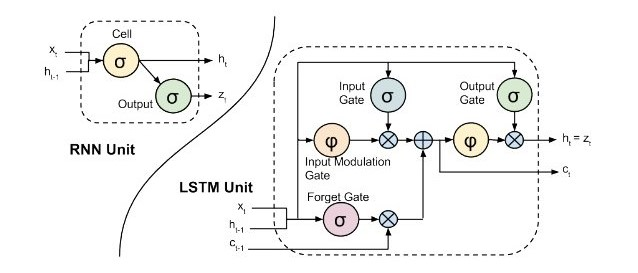

In [14]:
Image(filename='seqlearn.jpg')

## Encoder Definition

In [15]:
# Define Encoder:LSTMCell
encoder_cell = LSTMCell(encoder_hidden_units,reuse=tf.AUTO_REUSE) #20

# Dynamic RNN -> not only past,  but also takes future predictions into account

((encoder_fw_outputs,encoder_bw_outputs),(encoder_fw_final_state,encoder_bw_final_state)) =(
tf.nn.bidirectional_dynamic_rnn(
    cell_fw = encoder_cell,
    cell_bw=encoder_cell,
    inputs = encoder_inputs_embedded,
    sequence_length=encoder_inputs_length,
    dtype=tf.float32,time_major=True,scope=None)
) 


# Concatenate tensors in 1Dim - 'Bidirectional' step
encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c,encoder_bw_final_state.c),1)
encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h,encoder_bw_final_state.h),1)


# c -> Current cell state cell; h-> Output value of cell
# Create tuple for LSTMCell
encoder_final_state = LSTMStateTuple(
    c = encoder_final_state_c,
    h = encoder_final_state_h
)

## Decoder Definition

In [16]:
# Define decoder: LSTMCell
decoder_cell = LSTMCell(decoder_hidden_units)
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))
decoder_lengths = encoder_inputs_length + 3 #2 addnl steps

## Weights and Biases

In [17]:
# Define weights and biases
W = tf.Variable(tf.random_uniform([decoder_hidden_units,vocab_size],-1,1,dtype=tf.float32))
b = tf.Variable(tf.zeros([vocab_size]),dtype=tf.float32)

In [18]:
assert EOS == -1 and PAD == 0
eos_time_slice = tf.ones([batch_size],dtype=tf.int32,name='EOS')
pad_time_slice = tf.zeros([batch_size],dtype=tf.int32,name='PAD')
eos_step_embedded = tf.nn.embedding_lookup(embeddings,eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings,pad_time_slice)

### Decoder Functionality

In [19]:
def loop_fn_initial():
    initial_elements_finished = (0>=decoder_lengths)
    #eos
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None
    return(initial_elements_finished,
          initial_input,
          initial_cell_state,
          initial_cell_output,
          initial_loop_state)

#attention mechanism --choose which previously generated token to pass as input in the next timestep
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):
    def get_next_input():
        #dot product between previous ouput and weights, then + biases
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        #Logits simply means that the function operates on the unscaled output of 
        #earlier layers and that the relative scale to understand the units is linear. 
        #It means, in particular, the sum of the inputs may not equal 1, that the values are not probabilities 
        #(you might have an input of 5).
        #prediction value at current time step
        
        #Returns the index with the largest value across axes of a tensor.
        # This is the attention
        prediction = tf.argmax(output_logits, axis=1)
        #embed prediction for the next input
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

      
    #Computes the "logical and" of elements across dimensions of a tensor.
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    #Return either fn1() or fn2() based on the boolean predicate pred.
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    #set previous to current
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, input,state,output,loop_state)

def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

In [20]:
#Creates an RNN specified by RNNCell cell and loop function loop_fn.
#This function is a more primitive version of dynamic_rnn that provides more direct access to the 
#inputs each iteration. It also provides more control over when to start and finish reading the sequence, 
#and what to emit for the output.
#ta = tensor array
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [21]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [22]:
#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#reduces dimensionality
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
#flettened output tensor
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#pass flattened tensor through decoder
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
#prediction vals
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))



#final prediction
decoder_prediction = tf.argmax(decoder_logits, 2)

#cross entropy loss
#one hot encode the target values so we don't rank just differentiate
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



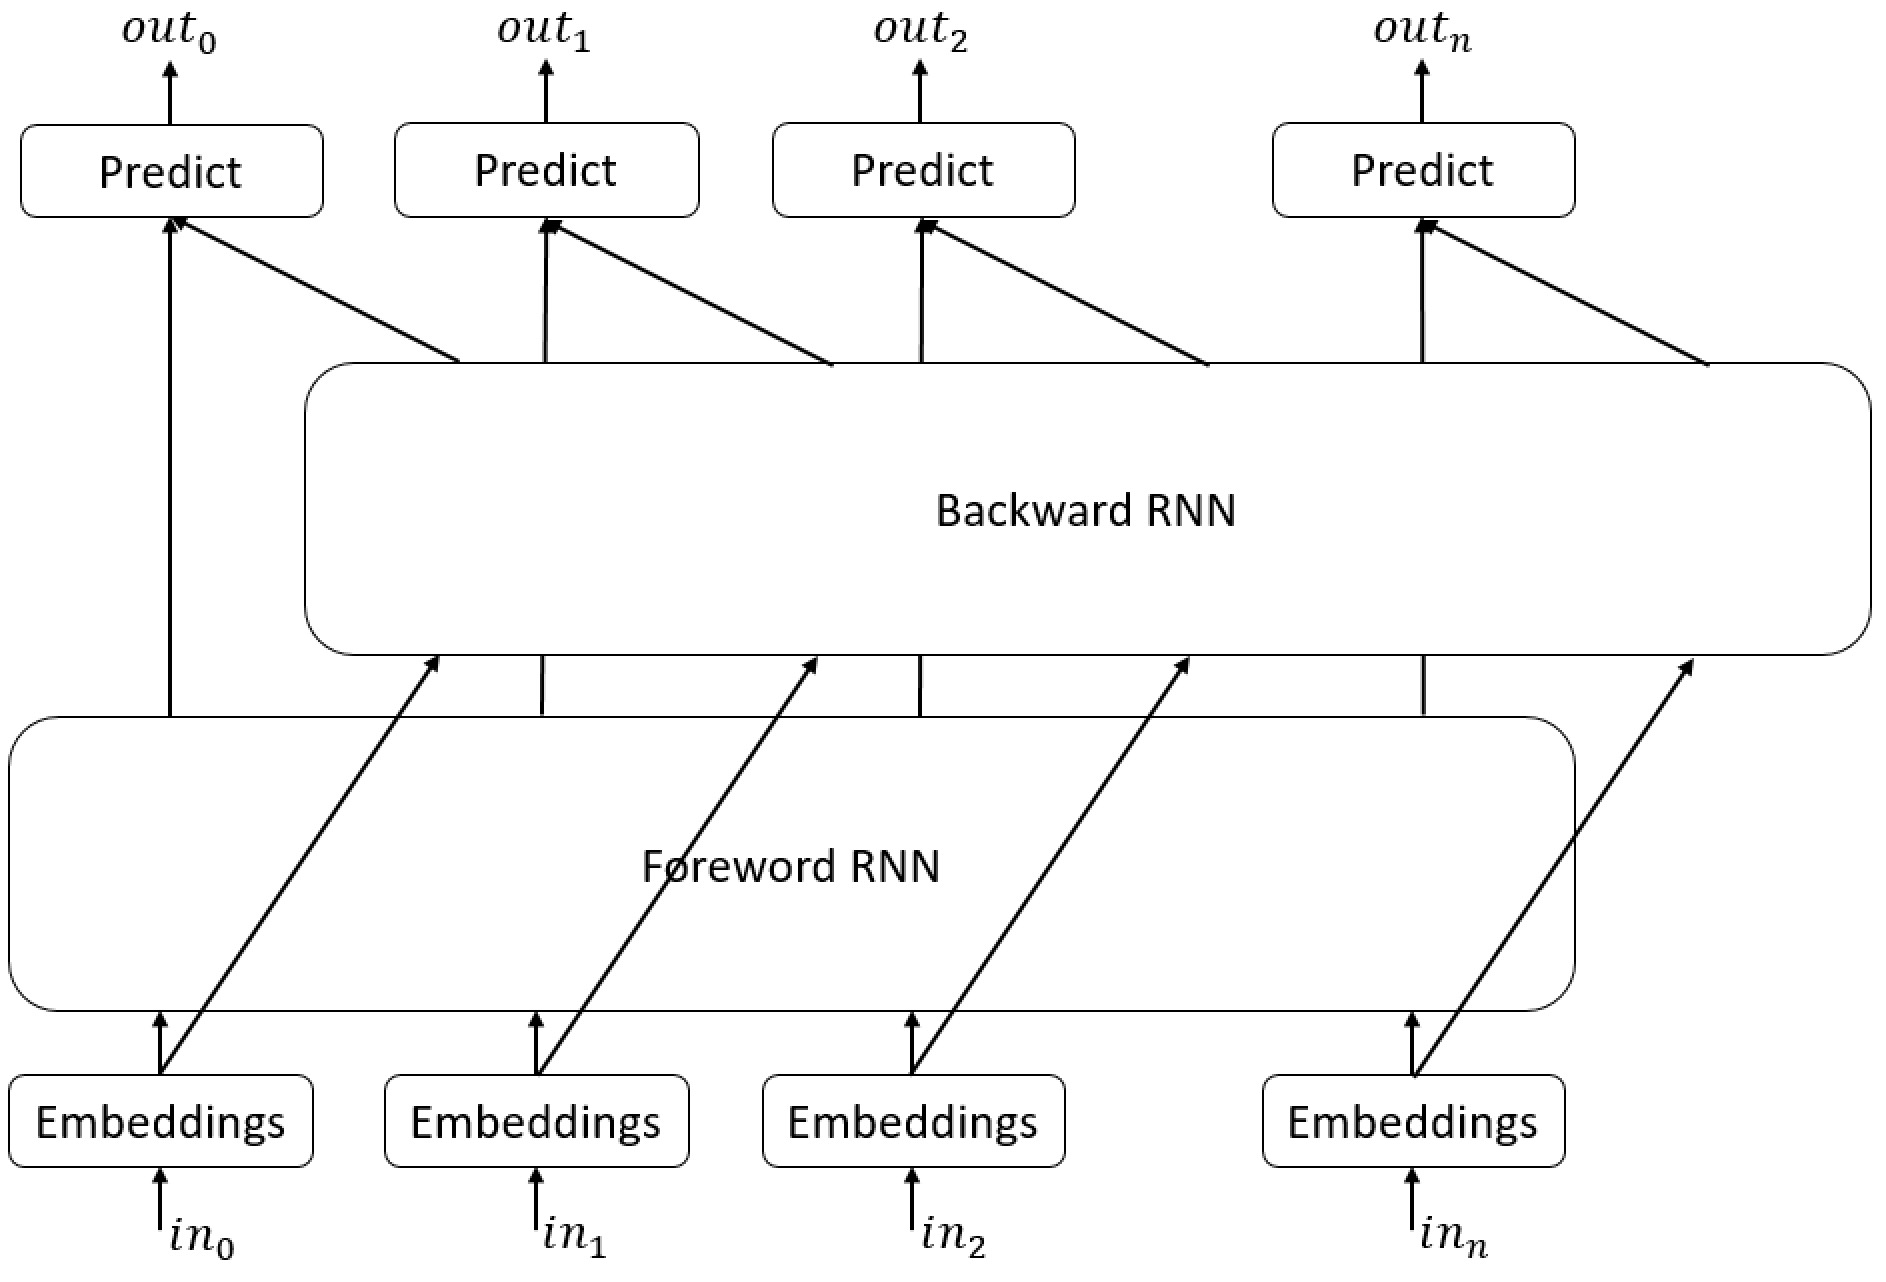

In [23]:
Image(filename='model.jpg')

## Training and Loss

In [24]:
# Define Loss function
loss = tf.reduce_mean(stepwise_cross_entropy)

#Train model to minimize loss
train_op = tf.train.AdamOptimizer().minimize(loss)

### Initialize Tensorflow Session

In [25]:
sess.run(tf.global_variables_initializer())

In [26]:
batch_size = 150
batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

for seq in next(batches)[:10]:
    print(seq)

[6, 7, 3, 5, 2, 5, 4, 6]
[8, 4, 7, 4]
[8, 4, 5, 6, 9]
[3, 5, 7, 8, 8]
[7, 7, 2]
[3, 8, 4, 2]
[4, 5, 9, 7, 3, 5]
[7, 4, 6, 2, 4, 3, 3]
[3, 7, 5, 9, 3, 6]
[5, 4, 9, 6, 7, 9]


In [27]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

loss_track = []

## Training Loop

In [28]:
max_batches = 10001
batches_in_epoch = 1000

# Training Iterations
try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 3.663193464279175
  sample 1:
    input     > [7 4 8 2 0 0 0 0]
    predicted > [20 28 11  5  5  5  5  0  0  0  0]
  sample 2:
    input     > [5 7 9 0 0 0 0 0]
    predicted > [20 28  5  5  5  5  0  0  0  0  0]
  sample 3:
    input     > [3 6 6 2 3 4 0 0]
    predicted > [20 16 16 16 11  5  5  5  5  0  0]

batch 1000
  minibatch loss: 1.4931751489639282
  sample 1:
    input     > [3 2 2 4 5 2 8 0]
    predicted > [2 4 8 8 8 2 7 0 0 0 0]
  sample 2:
    input     > [2 2 5 3 4 5 6 6]
    predicted > [9 9 3 8 8 2 2 2 0 0 0]
  sample 3:
    input     > [4 8 2 2 7 8 9 0]
    predicted > [9 9 8 8 8 2 7 0 0 0 0]

batch 2000
  minibatch loss: 1.2114157676696777
  sample 1:
    input     > [9 7 9 5 0 0 0 0]
    predicted > [9 9 9 9 9 0 0 0 0 0 0]
  sample 2:
    input     > [4 2 6 7 3 8 9 0]
    predicted > [7 7 7 7 9 9 9 0 0 0 0]
  sample 3:
    input     > [7 2 6 5 8 0 0 0]
    predicted > [6 5 5 6 6 0 0 0 0 0 0]

batch 3000
  minibatch loss: 0.9829146862030029
  

Loss: 0.7309 (after 1500150 examples)


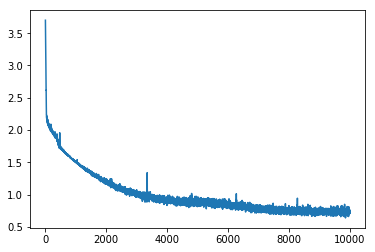

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('Loss: {:.4f} (after {} examples)'.format(loss_track[-1], len(loss_track)*batch_size))

## Some Decoded Output "Poetry"

In [30]:
def decode(output):
    decoded_input = [ivd[x] for x in output]
    if len(output) < 8:
        limit = 3
    else:
        limit = 4
    print(','.join(decoded_input[:limit]).replace(","," ")+",")
    print(','.join(decoded_input[limit:]).replace(","," ")+",")
    print("--")



output_1 = [4, 2, 7, 4, 4, 6]
output_2 = [5, 6, 7, 3, 3, 9, 9, 6]
output_3 = [4, 9, 5, 2, 9, 9, 5, 9, 2]

decode(output_1)
decode(output_2)

Three find In,
Three Three and,
--
all  and In Mortal,
Mortal the the and,
--


## References

* Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio. 2015. Neural machine translation by jointly learning to align and translate. ICLR.

* Minh-Thang Luong, Hieu Pham, and Christopher D Manning. 2015. Effective approaches to attention-based neural machine translation. EMNLP.

* Ilya Sutskever, Oriol Vinyals, and Quoc V. Le. 2014. Sequence to sequence learning with neural networks. NIPS.
BibTex